# Generative Adversarial Networks

## Auxiliary Classifer GAN

We've been discussing the basic ideas of using GANs in class, so we will only briefly review the ideas in this tutorial. Also, the assignment below is mainly focused on running the network yourself and generating the necessary output. The main thing to keep in mind is that you should not make any changes to the architecture below, just employ the training of it as suggested. It will take several hours for this network to train up, so please plan ahead to run the assignment. It should be straight-forward since you don't need to change any of the code below, but if you don't plan ahead, you may be stuck with a late penalty... please, just plan ahead.

OK, so we are going to use a GAN to create a network what can generate **fake** images of digits by using the MNIST data set for training. When we are finished, we will have a generator network capable of create random digits (of our choosing!) that the network *never experienced* during training. Normally, we are hoping to make networks with good *generalization* capabilities, but now they will have good *generative* capabilities.

This kind of network is known as an *Auxiliary Classifier Generative Adversarial Network* (AC-GAN), and you can read about the details if you are interested in this paper: [LINK](https://arxiv.org/abs/1610.09585)

The key difference between this kind of GAN and the ones discussed in class is this ability to utilize the classification labels to contruct new examples for the class of interest. Otherwise, you would need to sample many random inputs in a typical GAN until you found a good example, manually.

We will construct two networks: generator and discriminator. The generator is designed to take random noise and a class label, and generate an appropriate image. The discriminator will take an image and decide whether it is real/fake and also try to predict the class label as well. The networks will be forced to trade-off loss on one-another. When the discriminator is good at telling the difference between the MNIST images and the generators images, then the generator will be forced to make images more like MNIST digits. When the generator creates images that look more like a typical MNIST digit, then the discriminator will be forced to make more careful decisions about what images are real and which are faked.

Let's collect some tools for the job...

In [2]:
# Let's collect some tools for this job...
import tensorflow.keras as keras
import tensorflow.keras.backend as K

import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

First, we will set up the general parameters for the data set we will be learning on. Basically, the MNIST digits are all 28x28 pixels, and there are 10 different digits (0-9), while we would like to use random Gaussian noise vectors of length 100 for input to the generator. Again, this noise just allows for wide variation in the requested images, and 100 dimensions to work with will give it plenty of space.

In [3]:
# General parameters
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100

It's time to build our generator network, and this network requires that we start with a class label and random noise, then end with an image output. It is basically like a *inverse* convolutional neural network. We will take the integer class labels and project them into a 100 dimensional space (matching the noise space) and then multiply the noise times this embedding to create the final input that flows through this inverse network. Things like up-sampling and batch normalization are used instead of pooling to perform such operations.

The output layer is convolutional, so it produces an output that is the correct shape (84x84) at the end of this process. Don't change these settings when building your generator for the assignment!

In [4]:
# Generator

# Input layers setup [one for noise and one for class label]
noise = keras.layers.Input(shape=(latent_dim,))
label = keras.layers.Input(shape=(1,), dtype='int32')
label_embedding = keras.layers.Flatten()(keras.layers.Embedding(num_classes, 100)(label))
generator_input = keras.layers.Multiply()([noise, label_embedding])

# Generation of hidden layer structures
generator_hidden = keras.layers.Dense(128 * 7 * 7, activation='relu')(generator_input)
generator_hidden = keras.layers.Reshape((7, 7, 128))(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(128, kernel_size=2, strides=2,
                                                activation='relu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2,
                                                activation='relu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
g_image = keras.layers.Conv2DTranspose(channels, kernel_size=3,
                                       padding='same', activation='tanh')(generator_hidden)

# Finalize the model
generator = keras.Model([noise, label], g_image)
generator.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(0.0002,0.5))

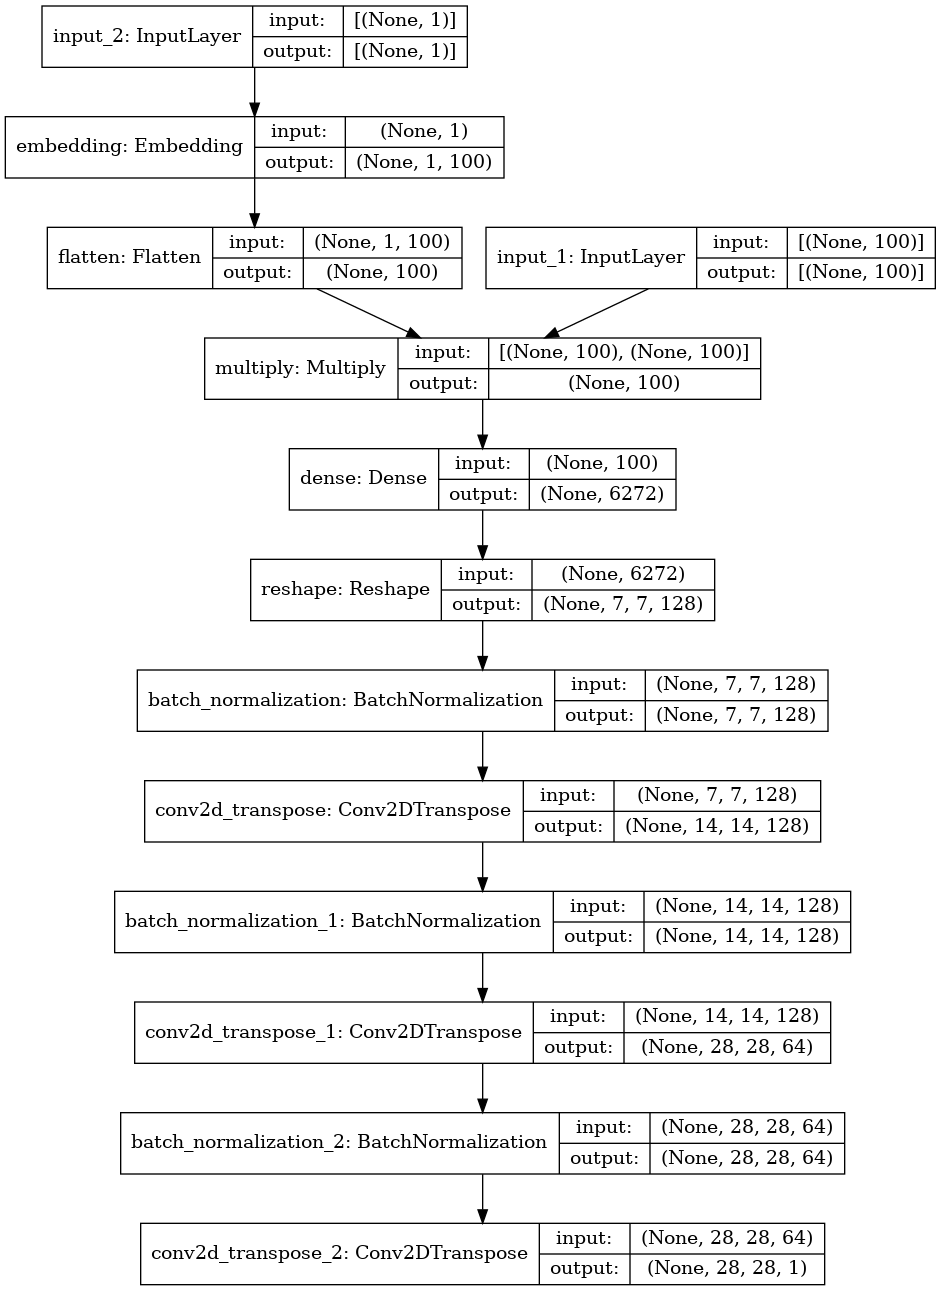

In [5]:
# Generator model structure
keras.utils.plot_model(generator,to_file="generator.png",
                       show_shapes=True,expand_nested=True)

Now on with the discriminator!

This network will take an image as input and then decide two things (two output layers). The first is whether it is a real or fake image (% real, using sigmoid activation), and the second is what class it thinks the image belongs to (softmax, one-hot). However, we add one additional class for all "fake" images since they technically aren't going to be *real* types of any of those classes. This is a little non-intuitive, but learning categories for fake images would be really confusing in some ways for the network (there are lots of ways to produce fakes, so there are just too many possibilities to consider).

Let's build this network now...

In [6]:
# Discriminator

# Input for discriminator model is an image...
d_image = keras.layers.Input(shape=img_shape)

# Hidden layers
discriminator_hidden = keras.layers.Conv2D(16, kernel_size=3, strides=2,
                                           padding='same')(d_image)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(32, kernel_size=3, strides=2,
                                           padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.BatchNormalization(momentum=0.8)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(64, kernel_size=3, strides=2,
                                           padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.BatchNormalization(momentum=0.8)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(128, kernel_size=3, strides=1,
                                           padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Flatten()(discriminator_hidden)

# Outputs will be both a probability of being "real" and...
valid = keras.layers.Dense(1, activation='sigmoid')(discriminator_hidden)
# A probability of what class (with fakes having a unique class (+1))
target_label = keras.layers.Dense(num_classes+1,
                                  activation='softmax')(discriminator_hidden)

# Finalize the model
discriminator = keras.Model(d_image, [valid, target_label])
discriminator.compile(loss=[keras.losses.BinaryCrossentropy(),
                            keras.losses.SparseCategoricalCrossentropy()],
                      optimizer=keras.optimizers.Adam(0.0002,0.5),
                      metrics=['accuracy'])

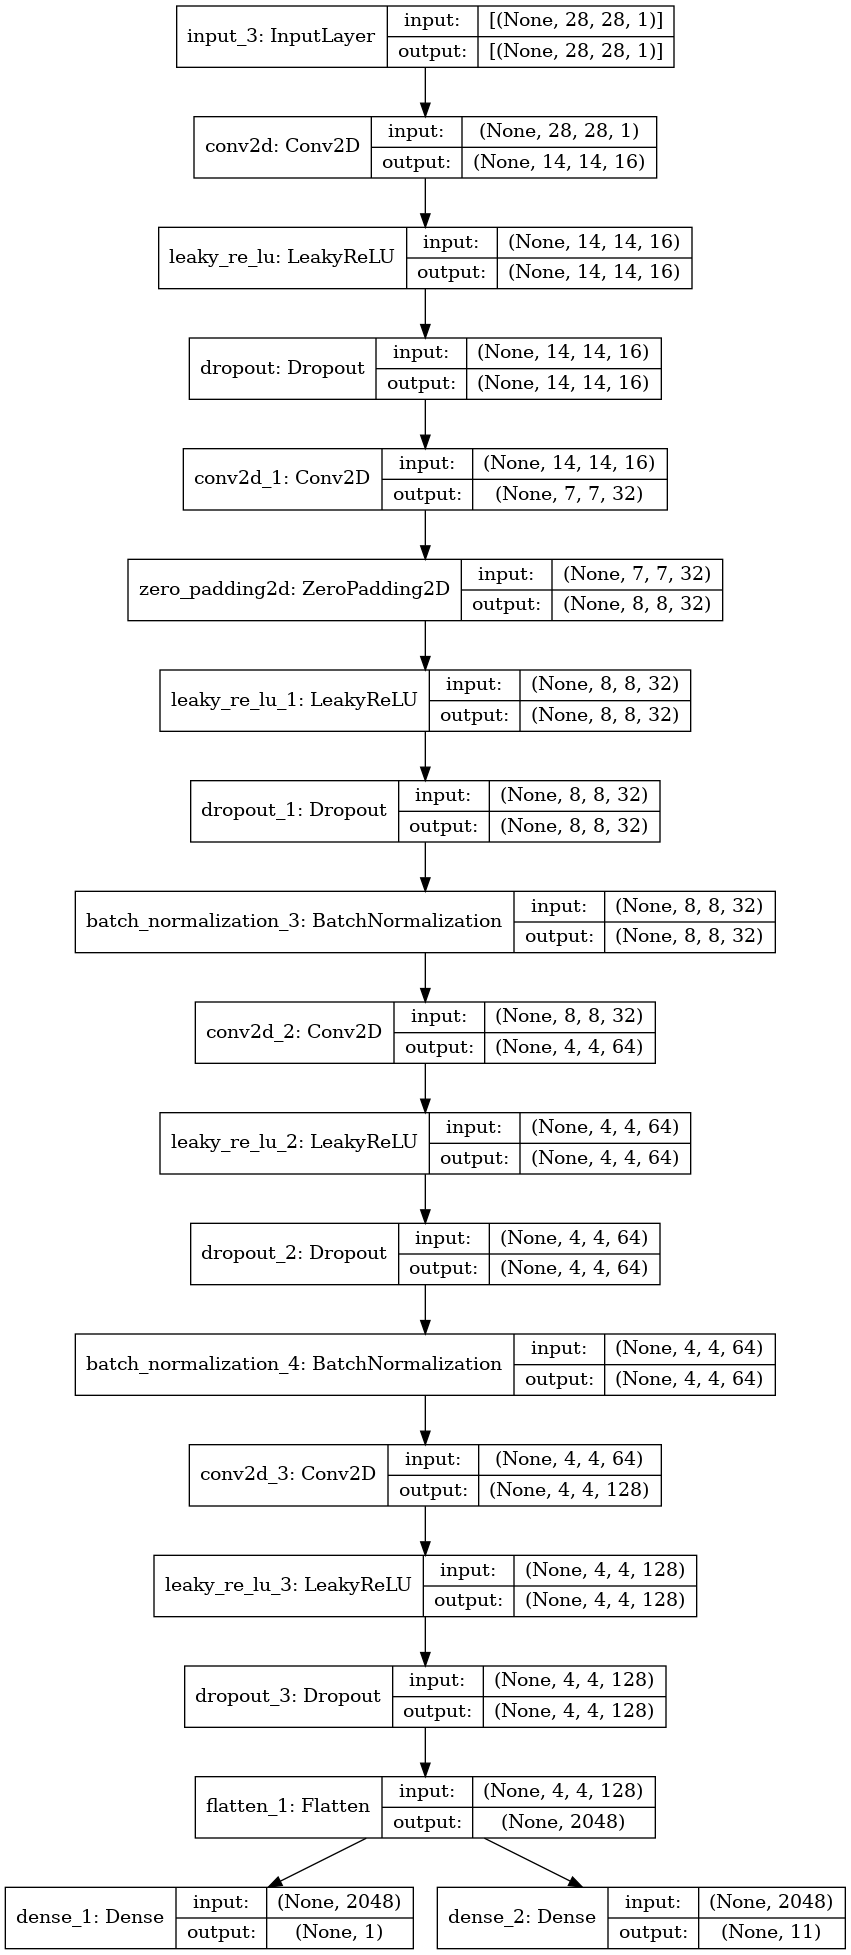

In [7]:
# Discriminator architecture
keras.utils.plot_model(discriminator,to_file="discriminator.png",
                      show_shapes=True,expand_nested=True)

Here's where the tricky part comes in. We need to be able to pass error information back through the discriminator and into the generator in order to update the weights in the generator. (Since we can't generate the images ourselves, we can't provide targets for the generator directly.) However, we also **do not** want the discriminator to learn when this happens since we are trying to *fake it out* or make incorrect classification between real/fake. So, we will create a *new model* which we will call **combined** that couples these together, but first we will *turn off training* for the discriminator before doing so.

This will leave the discriminator trainable using `discriminator` but not trainable using `combined` even though they share the same layers and weights. We will also get a **warning** message below from Keras when we try to do this since it will think this might not be what we intended to do. We can safely ignore it because it **is** what we wanted, but we'll get to that soon enough...

The key idea here is to just attach the output layer from the generator (`g_image`) as input to the discriminator model, which the functional API will let us do just by calling the model's function (`discriminator(g_image)`). The output layers from this function call will be recored (and technically don't change, but are now untrainable) and are used to construct our new *combined model*. Again, those are real/fake probabilities and then the predicted categories. This new model takes the noise and requested class label, creates an image, and then tests that image using the discriminator to provide feedback for the **trainable** part of the network (i.e. the generator). 

In [8]:
# Combined model...

# When training the generator, we need to pass through the discriminator...
# However, we don't want the discriminator to update during training
# of the generator (which would generate a -moving target- problem
# similar to RL agents)

# So, we will turn the discriminator training -off- when training with
# the combined model (combined model is really -only- used to train
# the generator even though it shares layers with the "trainable"
# discriminator that we made earlier)

# Turn off learning for generator...
discriminator.trainable = False

# Make the output of the generator feed into the discriminator.
# Note that we don't recompile the discriminator when doing this so that
# the discriminator can still be trained independently...
valid, target_label = discriminator(g_image) # g_image = generator output layer

# Combined model now takes generator inputs and has discriminator outputs...
combined = keras.Model([noise,label],[valid,target_label])
combined.compile(loss=[keras.losses.BinaryCrossentropy(),
                       keras.losses.SparseCategoricalCrossentropy()],
                 optimizer=keras.optimizers.Adam(0.0002,0.5))

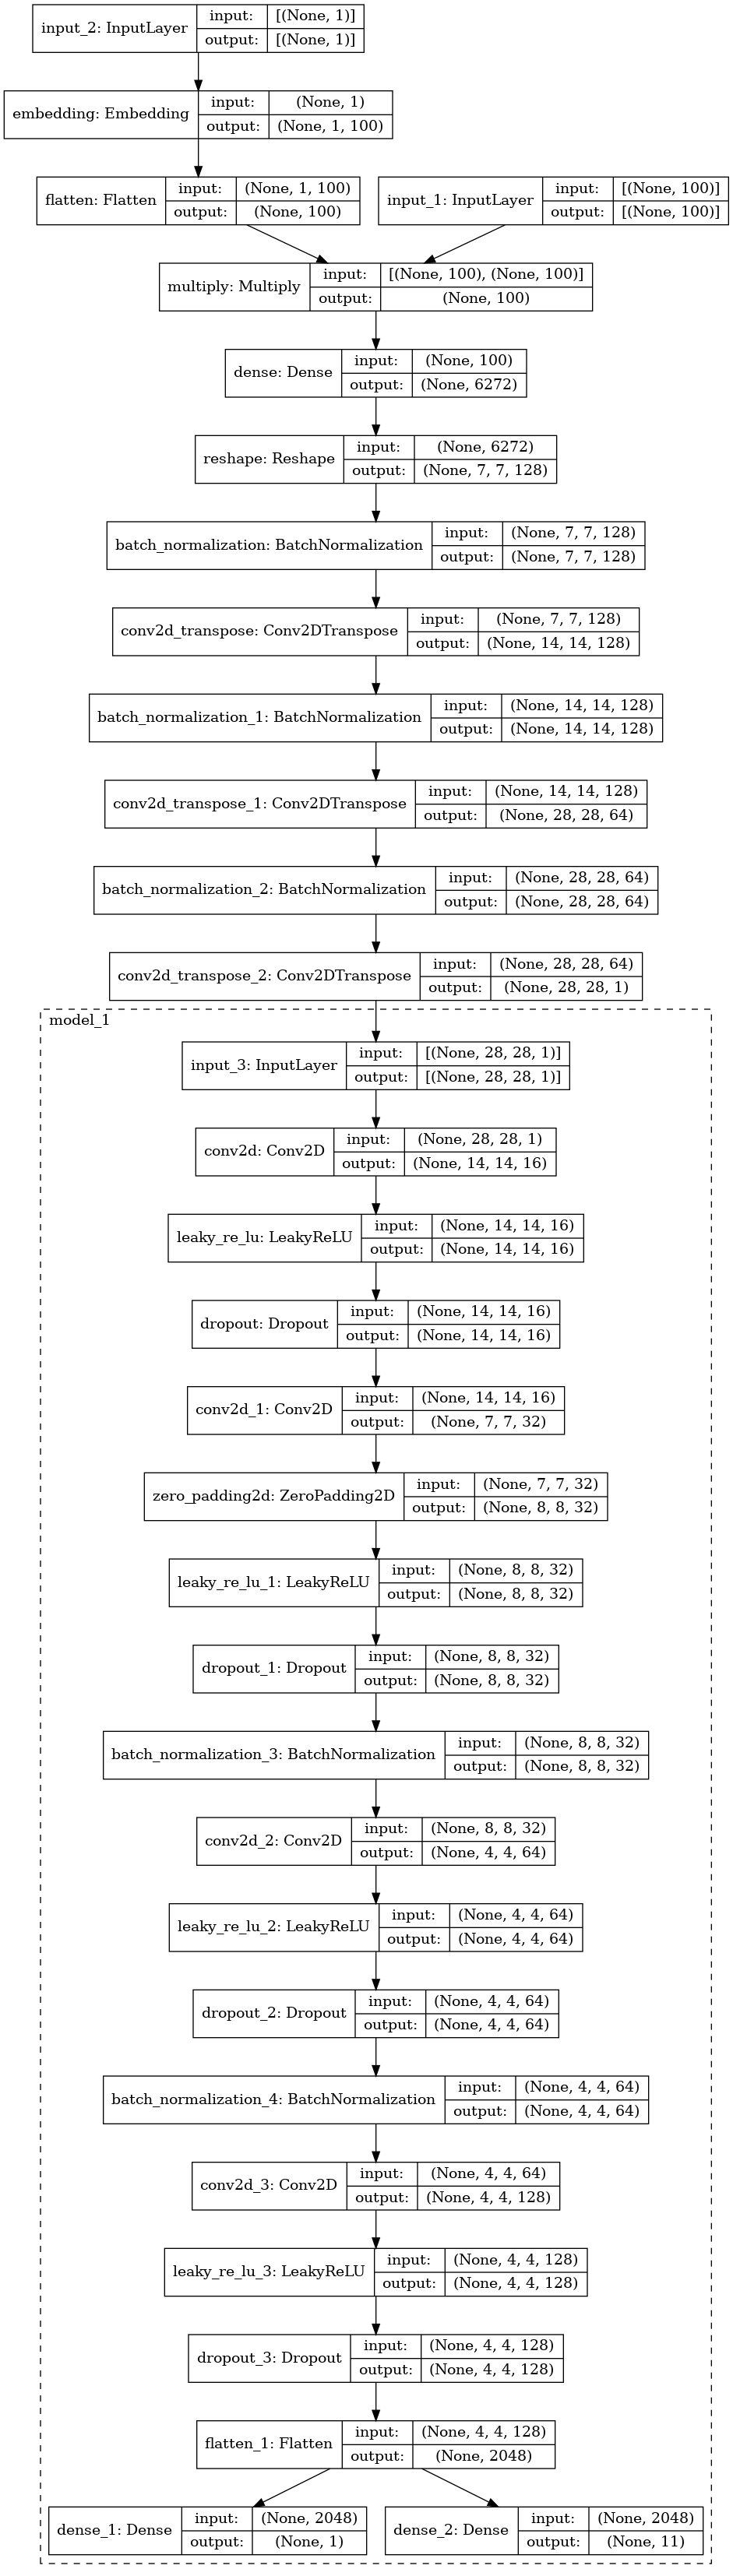

In [9]:
# Combined architecture - note that the discriminator part is not trainable!
keras.utils.plot_model(combined,to_file="combined.png",
                       show_shapes=True,expand_nested=True)

Now, we are just about ready to train our AC-GAN. First, we need to read in the training data, which should mostly be review at this point. The only new thing here is that we will **not** transform the class labels into one-hot encodings here since the generator's *embedding* layer is doing that for us in order to multiply it with the noise that we provide.

In [10]:
# Load image data - MNIST
(X_train, Y_train), (_, _) = keras.datasets.mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
Y_train = Y_train.reshape(-1, 1)

print(X_train.shape)
print(Y_train.shape)

(60000, 28, 28, 1)
(60000, 1)


MNIST training data: 60,0000 images, each 28x28x1 (greyscale channel only).

MNIST labels: integer class label for digits 0-9

Also, we will now set up some parameters for our training regime. First, we set up some list structures for storing history of loss and accuracy for plotting later on. Also, we set the batch size (number of images) that we want to train on for each epoch. Each epoch will first train the discriminator on a set that is one-half real and one-half fake images, so we determine the `half_batch_size` for convenience as well.

In [11]:
# Training Parameters
history = [[],[],[],[]]
batch_size = 32
half_batch_size = int(batch_size/2)

We are now ready for training to come together.

There are multiple phases to this process, and we will look at them a little in class instead of studying the details too much in the tutorial, but the comments below should also help with reminding you of what each part represents.

Generally, we first construct a set of fake images with the generator (random noise and random classes). We then combine that with a random sample of real images from the MNIST set. This data is then fed into the discriminator for **training**. We can provide feedback to the discriminator since we know which images are real and which are fakes. We also know which class label they should be assigned to (including the *extra* class for fakes).

After that, the generator is trained by using the combined model (where the discriminator's weights will *not* be updated). In this approach, we compute a full set of random noise and class labels, and feed them as input. The targets are provided so as to fake if they were *real* images and also assigned to the appropriate *target class*. This loss is propagated through the (now fixed) discriminator network, and only used in the generator layers deep in the combined model to push the weights to generate images that the discriminator would like to see for those classes.

By participating in this back-and-forth game, we can eventually train up a good generator which can make images of hand-written digits...

In [12]:
# Perform some number of batches...
batches = 10

# We need to perform this manually since the
# training is broken into phases for each
# component but still needs to be interleaved...
for batch in range(batches):

    # Training the discriminator...

    # Select half of the images for the discriminator from
    # the MNIST data set...
    idx = np.random.randint(0, X_train.shape[0], half_batch_size)
    real_images = X_train[idx]

    # Generate some Gaussian noise (random) 100-element vectors
    # to provide as inputs for the generator to make some "fakes"
    noise = np.random.normal(0, 1, (half_batch_size, 100))

    # We want those random vectors to be associated with a class...
    # That is, we are asking the generator to make these numbers...
    sampled_labels = np.random.randint(0, 10, half_batch_size).reshape(-1, 1)

    # Use the generator to make these images now!
    generated_images = generator.predict([noise, sampled_labels])

    # Generate the real-fake target distinctions
    # Reals are 1.0 (100% real)
    # Fakes are 0.0 (0% real)
    valid = np.ones((half_batch_size, 1))
    fake = np.zeros((half_batch_size, 1))

    # Use the labeled classes for the real images...
    image_labels = Y_train[idx]
    # Assign the fake images to the "extra class" or "fake class"
    # on the one-hot encoding for all fake images (they are
    # not any of the digits 0-9 since they are -fakes- so
    # we don't used the requested generator labels...)
    fake_labels = 10 * np.ones(half_batch_size).reshape(-1, 1)

    # Train the discriminator - Two groups
    d_loss_real = discriminator.train_on_batch(real_images, [valid, image_labels])
    d_loss_fake = discriminator.train_on_batch(generated_images, [fake, fake_labels])
    # Calculate the average for an "overall" loss/accuracy for the discriminator...
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    #  Training the generator...

    # Make some noise!
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Note that we are using the combined model to backprop the
    # loss to the generator... we therefore need to make some targets...
    
    # Call these real images! - we are trying to "fake-out" the
    # discriminator, so how would we accomplish this? Set the target
    # -as-if- the generated images were -real-!
    valid = np.ones((batch_size, 1))
    
    # Give them some labels so the generator can learn which digit
    # it is trying to fake.
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

    # Add new results to history for plotting later...
    history[0] += [d_loss[0]]
    history[1] += [d_loss[3]]
    history[2] += [d_loss[4]]
    history[3] += [g_loss[0]]

    # Print progress indicator
    print("\r%d [Disc. Loss: %f, Real/Fake-Acc.: %.2f%%, Class-Acc: %.2f%%] [Gen. Loss: %f]" % (
        batch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]),end='')

9 [Disc. Loss: 1.830031, Real/Fake-Acc.: 90.62%, Class-Acc: 50.00%] [Gen. Loss: 3.091883]

Note you might see a warning above, it's only there because of our GAN training regime, but isn't really a problem.

After training, we can print a history of the performance for the networks...

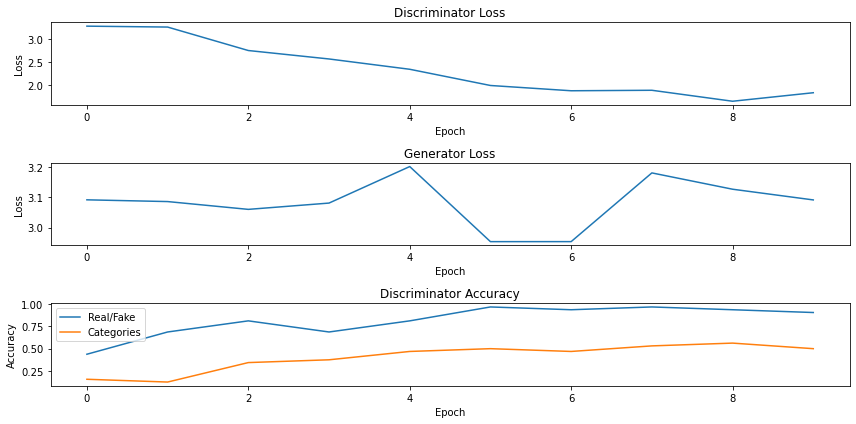

In [13]:
# Plot training history...
plt.figure(1,figsize=(12,6))  

plt.subplot(311)
plt.plot(history[0])  
plt.title('Discriminator Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  

plt.subplot(312)
plt.plot(history[3])  
plt.title('Generator Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  

plt.subplot(313)  
plt.plot(history[1])  
plt.plot(history[2])  
plt.title('Discriminator Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')
plt.legend(['Real/Fake', 'Categories'], loc='upper left')  

plt.tight_layout()
plt.show()  

You will see the loss and accuracy for both models go through phases of high and low during the training process as they attempt to **out-perform** one-another. This is normal, and can make it difficult to know when you are finished. The only way to do this would be to examine the kinds of outputs that the generator is making and we do this below... 

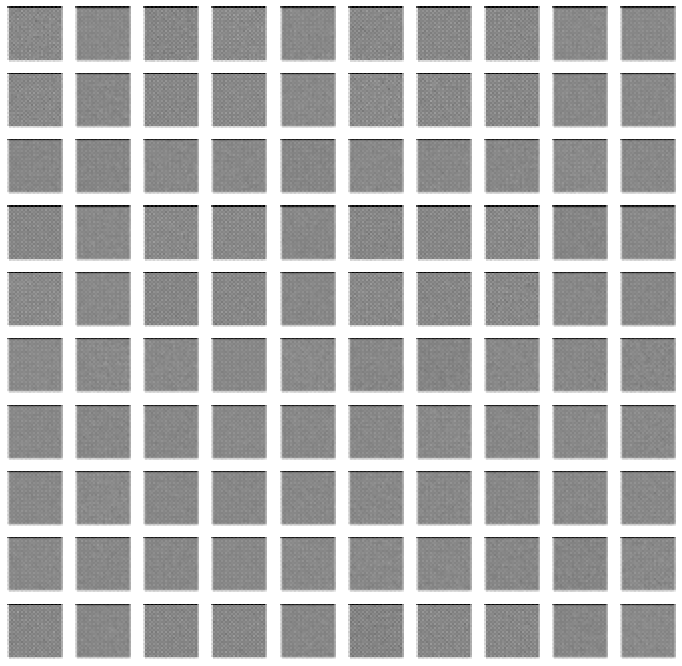

In [14]:
## Testing
r, c = 10, 10
noise = np.random.normal(0, 1, (r * c, 100))
sampled_labels = np.array([num for _ in range(r) for num in range(c)])

# Make some fakes!
generated_images = generator.predict([noise, sampled_labels])
# Rescale images 0 - 1
generated_images = 0.5 * generated_images + 1

# Plot them...
fig, axs = plt.subplots(r, c)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(generated_images[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1
plt.show()

The above examples only show the results after 10 batches of training, so it's no surprise that nothing interesting has started to develop. However, after 5,000 to 20,000 batches, things will be different.

Note that the code below is the same as the code above, but provides intended results for comparison. At the end of your training batches, you should be able to use your generator model to create some images of hand-written digits. These are **not real**, they were merely **created** by the GAN above using just *random noise* and a class label (i.e. give me a number, please and thank you!).

Such generative properties are useful for training systems where predicting a wide variety of plausible, but unexperienced situations, may be useful for training (reinforcement learning, game playing, planning, etc.)

Your final results to the assignment below should look similar...

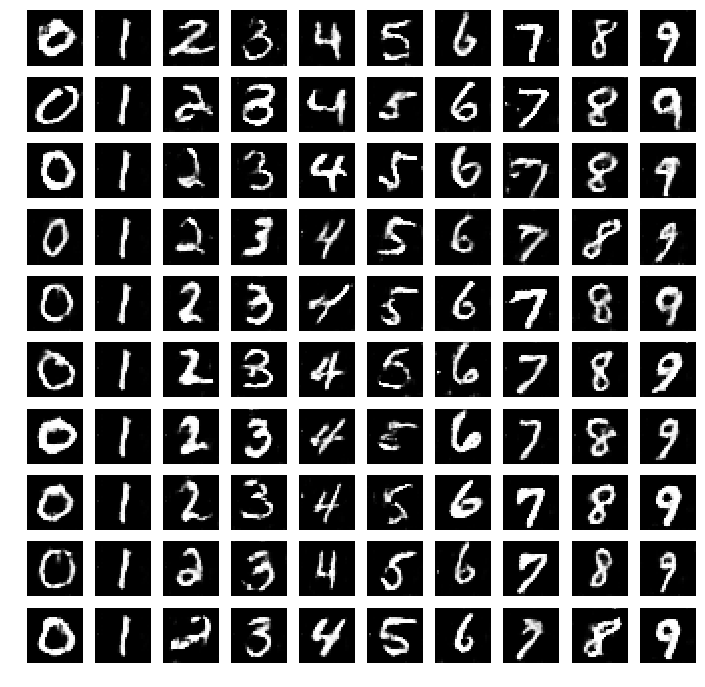

In [14]:
## Testing
r, c = 10, 10
noise = np.random.normal(0, 1, (r * c, 100))
sampled_labels = np.array([num for _ in range(r) for num in range(c)])

# Make some fakes!
generated_images = generator.predict([noise, sampled_labels])
# Rescale images 0 - 1
generated_images = 0.5 * generated_images + 1

# Plot them...
fig, axs = plt.subplots(r, c)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(generated_images[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1
plt.show()

## Potential Problem: Mode Collapse

At some point, you may observe that the **generator loss** curve *increases rapidly to a large value*. This is an indication of *mode collapse* where the generator has become trapped in a local minimum in the true problem error surface and the discriminator is taking advantage of that fact (discriminator's loss will be low as a result). The resulting images will then look either very grainy or all very similar to one-another indicating that the generated digit distribution has collapsed to this local minimum configuration for pretty much any random input.

The easiest way to prevent mode collapse is to simply practice early stopping: the code above will let you specify the number of batches to run and the code block can be rerun several times without losing loss/accuracy history information. As a result, running in sets or 1000 or 2000 batches will often help you find a point where the discriminator loss looks pretty noisy (like it's having trouble finding the difference between real/fake) and also the generator loss is relatively low (like it's making decent images which confuse the discriminator). You should test the images produced at this point before performing additional training since you may move into mode collapse shortly after this phase. There are improvements to the GAN method that can help prevent this from happening, but those will have to be explored in another tutorial.

For some models, you can continue training and the generator will eventually climb out of it's mode-collapsed state due to the stochastic nature of SGD, but this can take a **very** long time to accomplish. As a result, undertraining instead of overtraining is the recommended approach here. Good luck!